# Image inpainting

Example of image inpainting using NIHT applied to nearfield acoustic holography data.

First load packages

In [1]:
import sys
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt
import cv2

import pylops

import scipy.io as sio

from nopt.transforms import *
from nopt.constraints import *
from nopt.problems import *
from nopt.solvers import *

Now load the (complex) data

In [2]:
# Load image
mat_contents = sio.loadmat('../data/PressureZ0.mat')
u0: np.float64 = 0.1155
c0: np.float64 = 1500.0
rho0: np.float64 = 1000.0
p0: np.float64 = u0 * c0 * rho0
img: np.ndarray = p0 * np.conj(mat_contents['out'])

Nx, Ny = np.shape(img)

delta: float = 0.5
rho: float = 0.1
p: int = round(delta * Nx * Ny) # number of samples
s: int = round(p * rho) # sparsity

mask = np.random.choice(Nx * Ny, p, replace=False)

P_omega = EntryWise(mask, Nx * Ny)

Wave2d = pylops.signalprocessing.DWT2D(img.shape, level=2, wavelet = 'db4')

img_coeff = Wave2d.matvec(img.flatten())

The model is:

$$ 
\min_c \| P_\Omega( \Psi^*(c) )) - b \|_2 \qquad \mathrm{such~that} \qquad \|c\|_0 \leq s
$$

where $P_\Omega$ is an entrywise subsampling and $\Psi$ is an 2D Wavelet transform.

In [3]:
A = CompositeTransform([Wave2d.adjoint(), P_omega])
HTs = Sparsity(s)
b = P_omega.matvec(img.flatten())

sub, x_true = HTs.project(img_coeff)
problem = LinearProblem(A, b, HTs, x_true = x_true)
solver = NIHT(logverbosity = 2, maxiter = 100, verbosity = 2, minreldecrease = 1-1e-3)

Now solve:

In [4]:
x, opt_log = solver.solve(problem)

C:\Users\dsinden\GitHub\pynopt\examples\..\nopt\transforms\entry_wise.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  _x[self._mask] = y


 iter		   obj. value	    grad. norm	     xdist
    1	+4.1574320439985325e+14	8.74670067e+06
    2	+4.0880834602634469e+14	7.53133704e+06
    3	+4.0781635326562325e+14	6.54609202e+06
    4	+4.0552370802041688e+14	6.39275647e+06
    5	+4.0519661778056312e+14	6.02345788e+06
    6	+4.0407438766869144e+14	5.96890813e+06
    7	+4.0396948166889175e+14	5.77783732e+06
    8	+4.0319301925715288e+14	5.75965208e+06
    9	+4.0325057437330319e+14	5.62322570e+06
   10	+4.0255963118649306e+14	5.63345165e+06
   11	+4.0275970013733919e+14	5.50943655e+06
   12	+4.0204950694497594e+14	5.54563153e+06
   13	+4.0247001019684644e+14	5.41605416e+06
   14	+4.0161456363862006e+14	5.49314565e+06
   15	+4.0226140509241300e+14	5.33514349e+06
   16	+4.0122732931873475e+14	5.45503794e+06
   17	+4.0198351569736925e+14	5.26206113e+06
Terminated - min relative decrease reached after 17 iterations, 6.55 seconds.



and plot

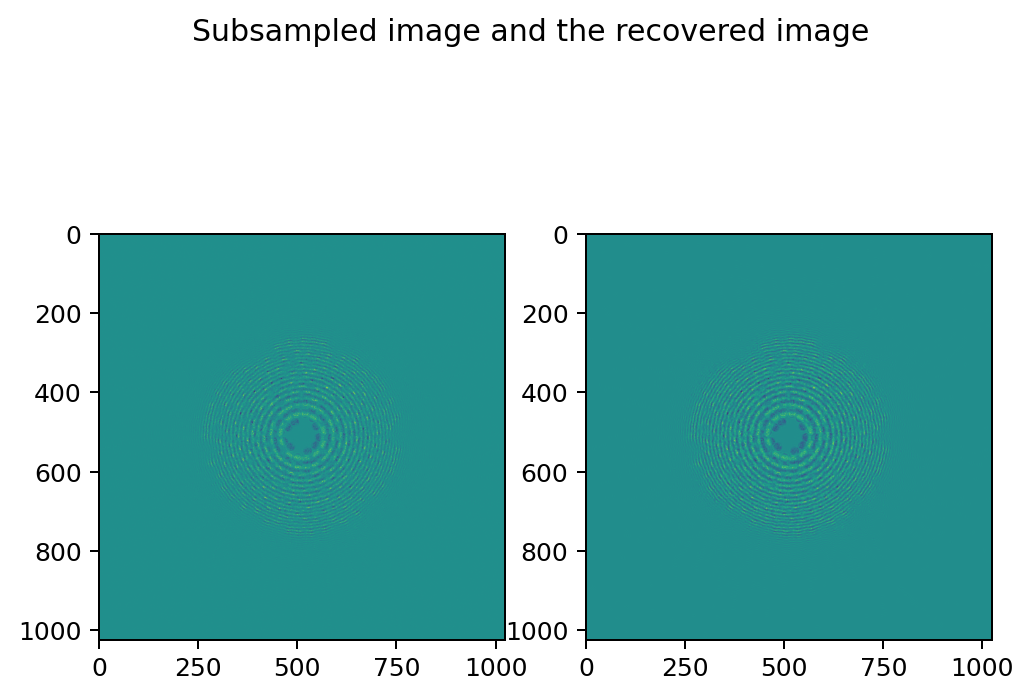

In [5]:
fig, axs = plt.subplots(1,2, dpi=180)
fig.suptitle('Subsampled image and the recovered image')
plt1 = axs[0].imshow(P_omega.rmatvec(b).reshape(Nx,Ny))
plt2 = axs[1].imshow(Wave2d.rmatvec(x).reshape(Nx,Ny))
plt.show()

The convergence is:

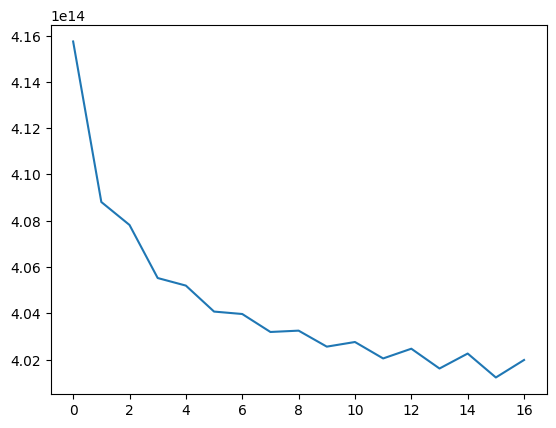

In [6]:
plt.plot(opt_log['iterations']['fx'])

In [8]:
delta: float = 0.5
rho: float = 0.1
p: int = round(delta * Nx * Ny) # number of samples
s: int = round(p * rho) # sparsity

img = img.imag

mask = np.random.choice(Nx * Ny, p, replace=False)

P_omega = EntryWise(mask, Nx * Ny)

Wave2d = pylops.signalprocessing.DWT2D(img.shape, level=2, wavelet='db4')

img_coeff = Wave2d.matvec(img.flatten())

A = CompositeTransform([Wave2d.adjoint(), P_omega])
HTs = Sparsity(s)
b = P_omega.matvec(img.flatten())

sub, x_true = HTs.project(img_coeff)
problem = LinearProblem(A, b, HTs, x_true = x_true)
solver = NIHT(logverbosity = 2, maxiter = 100, verbosity = 2, minreldecrease = 1-1e-3)

In [9]:
x, opt_log = solver.solve(problem)

 iter		   obj. value	    grad. norm	     xdist
    1	+nan	0.00000000e+00
Terminated - min grad norm reached after 1 iterations, 0.32 seconds.



C:\Users\dsinden\GitHub\pynopt\examples\..\nopt\solvers\niht.py:17: RuntimeWarning: invalid value encountered in scalar divide
  return a/b


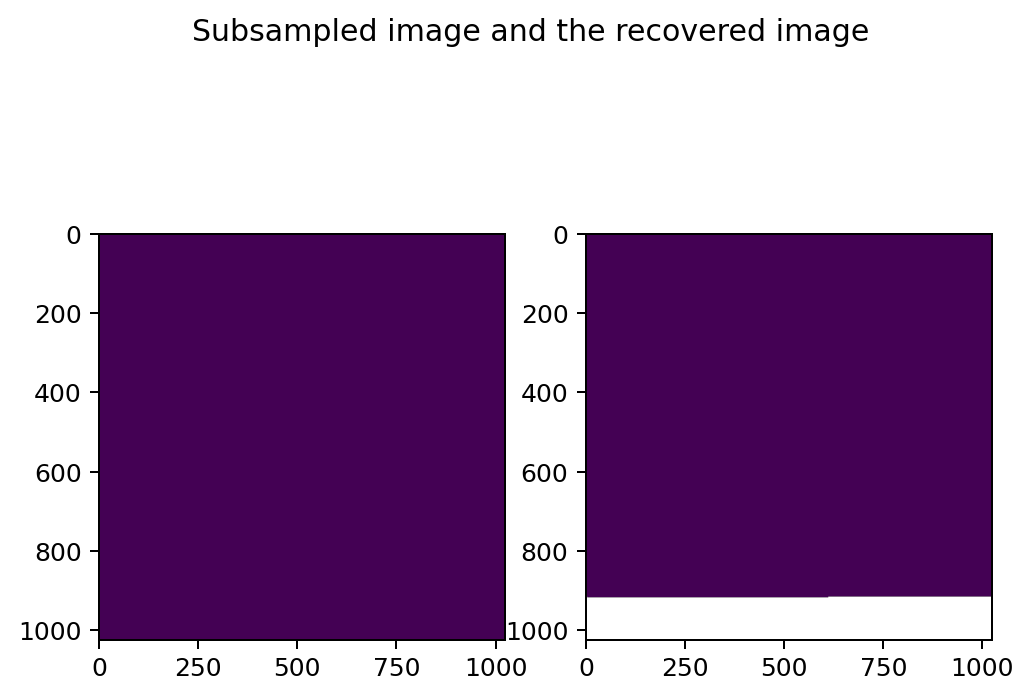

In [10]:
fig, axs = plt.subplots(1,2, dpi=180)
fig.suptitle('Subsampled image and the recovered image')
plt1 = axs[0].imshow(P_omega.rmatvec(b).reshape(Nx,Ny))
plt2 = axs[1].imshow(Wave2d.rmatvec(x).reshape(Nx,Ny))
plt.show()